In [97]:
import string
import random
import numpy as np
import matplotlib.pyplot as plt
import requests
import os
import re
import textwrap

### 构建替换密码字典(substitution cipher)

In [98]:
### create substitution cipher

# 一个列表作为key 另外一个作为value

letter1 = list(string.ascii_lowercase)   #将26个小写英文字母变成列表
letter2 = list(string.ascii_lowercase)

true_mapping ={}

# 将letter2里面的字母顺序打乱
random.shuffle(letter2)
print('打乱后的字母表\n',letter2)

# 将key 和 value对应输入到字典里

for k,v in zip(letter1,letter2):
    true_mapping[k] =v

print('替换密码字典:', true_mapping)


打乱后的字母表
 ['s', 'l', 'c', 'b', 'w', 'z', 'f', 'm', 't', 'p', 'r', 'n', 'h', 'e', 'x', 'u', 'o', 'j', 'i', 'd', 'a', 'q', 'v', 'k', 'y', 'g']
替换密码字典: {'a': 's', 'b': 'l', 'c': 'c', 'd': 'b', 'e': 'w', 'f': 'z', 'g': 'f', 'h': 'm', 'i': 't', 'j': 'p', 'k': 'r', 'l': 'n', 'm': 'h', 'n': 'e', 'o': 'x', 'p': 'u', 'q': 'o', 'r': 'j', 's': 'i', 't': 'd', 'u': 'a', 'v': 'q', 'w': 'v', 'x': 'k', 'y': 'y', 'z': 'g'}


替换密码字典只有发送人和接受人知道，用来直接解密。但是你是情报间谍，要在不知道这个替换密码字典的情况下，将密码破解。

### 语言模型 Language Model

$$ P(ABC) = P(C|AB) * P(AB) $$
因为后一个字母的概率只和前一个字母出现的概略有关
$$ P(C|AB) = P(C|B) $$
所以原式可以写成
$$ P(ABC) = P(C|B) * P(B|A)* P(A) $$
通用公式为
$$ P(x_1.....x_n) = P(x_1)\prod_{t=2}^{n}p(x_{t}|x_{t-1}) $$
因为累乘太麻烦，而且每个条件概率又是非常小，这样乘出来的概率更小了。所以用log-probability 将其变为累加
我们不用关心真实的概率是怎样的，只需要比较出log—probability最大的句子即可，这就是最接近真实的句子
$$ log(P(x_1.....x_n)) = log(p(x_1)) + \sum_{t=2}^{n}log(p(x_{t}|x_{t-1}) $$

In [99]:
### the language model


# initialize Markov matrix 创建的Markov矩阵用来储存 「条件概率」，
# 因为有26个英文字母，所以是26*26的矩阵。每一个格子（i，j）都代表字母（j）在字母（i）之后出现的概率 

M = np.ones((26,26))

M_3 = np.ones((26,26,26))

# initial state distribution 创建每个字母单独的频次

pi = np.zeros(26)

# 更新Markov matrix

def update_transition(ch1, ch2):
    # ord('a') = 97, ord('b') = 98, ...
    i = ord(ch1)-97          #将字母字符通过ascii码转换成数字，这样就能用Markov martix 的索引来表示字母的位置
    j = ord(ch2)-97
    M[i,j]+=1


def update_transition_3(ch1,ch2,ch3):
    i = ord(ch1)-97
    j = ord(ch2)-97
    k = ord(ch3)-97
    M_3[i,j,k] +=1

# 更新频次矩阵
def update_pi(ch):
    i = ord(ch)-97
    pi[i] +=1

    
# get the log-probability of a word / token 计算一个词的log-probability
def get_word_prob(word, mode = 2):
    
    
    
    #首先取得这个词首字母的概率
    i = ord(word[0])-97       #记住这个i，他除了扮演第一个字母的索引外，还要不断更新扮演其他字母的前一个字母
    logp = np.log(pi[i])  
    if mode ==2:
        #然后对后面的对数条件概率进行累加
        for char in word[1:]:
            j = ord(char)-97
            logp += np.log(M[i,j])
            i = j                 #这一步是不断更新的操作
        

    elif mode ==3 and len(word)>1:
        #先算出一个bi-gram
        
        j = ord(word[1])-97
        logp += np.log(M[i,j])
        
        #然后对后面的tri-gram进行条件概率累加
        for char in word[2:]:
            k = ord(char)-97
            logp += np.log(M_3[i,j,k])
            i = j                #不断更新两个参数
            j = k
    return logp
            


#如果输入的是一句话，我们也要求出这句话的log-probability
def get_sequence_prob(words, mode):
    
    #如果这句话是以string的格式输入的，要进行分词操作
    if type(words)==str:         #注意这个判断
        words= words.split()     #如果是中文，还要进行中文分词
    
    
    logp = 0 
    for word in words:
        logp += get_word_prob(word,mode)
    
    return logp
    

In [100]:
### create a markov model based on an English dataset
# is an edit of https://www.gutenberg.org/ebooks/2701
# (I removed the front and back matter)

# download the file
if not os.path.exists('moby_dick.txt'):
    print("Downloading moby dick...")
    r = requests.get('https://lazyprogrammer.me/course_files/moby_dick.txt')

    with open('moby_dick.txt', 'w') as f:
      f.write(r.content.decode())


In [101]:
regex = re.compile('[^a-zA-Z]')

#从文件中读取文字
for line in open('moby_dick.txt'):         #直接打开读取每一行，是字符串
    
    line = line.rstrip()                   #把每一行右边的空格给去掉了
#     print(line)
    if line:                               #有些空行，无法用regex，所以要判断一下
        line = regex.sub(' ',line)          #将非字符的东西替换成空格
    
    tokens = line.lower().split()           #将这一行所有字符都变成小写，然后分词
    
#     print(tokens)
    for token in tokens:
        
        
        #首字母更新频次
        ch0 = token[0]
        update_pi(ch0)
        
        
        
        #其余字母更新频次-bigram
        for ch1 in token[1:]:
            update_transition(ch0,ch1)
            ch0 = ch1
            
        #其余字母更新频次 tri-gram
        if len(token)>2:
            ch0 = token[0]
            ch1 = token[1]
            for ch2 in token[2:]:
                update_transition_3(ch0,ch1,ch2)
                ch0 = ch1
                ch1 = ch2
        
#将频次转换成概率
pi /= sum(pi)                               #每个字母的概率是频率直接除以总数即可

M /= M.sum(axis=1,keepdims = True)          #按行除，算出条件概率之和需要等于1. 
                                            #axis= 1是按行加总，shape是（26，1），aixs =0 则是按列加总，shape是（1，26）

    
a = M_3.sum(axis =2,keepdims = True)
b = a.sum(axis =1, keepdims = True)
M_3 /= b

In [102]:
### encode a message

# this is a random excerpt from Project Gutenberg's
# The Adventures of Sherlock Holmes, by Arthur Conan Doyle
# https://www.gutenberg.org/ebooks/1661

original_message = '''I then lounged down the street and found,
as I expected, that there was a mews in a lane which runs down
by one wall of the garden. I lent the ostlers a hand in rubbing
down their horses, and received in exchange twopence, a glass of
half-and-half, two fills of shag tobacco, and as much information
as I could desire about Miss Adler, to say nothing of half a dozen
other people in the neighbourhood in whom I was not in the least
interested, but whose biographies I was compelled to listen to.
'''

# Away they went, and I was just wondering whether I should not do well
# to follow them when up the lane came a neat little landau, the coachman
# with his coat only half-buttoned, and his tie under his ear, while all
# the tags of his harness were sticking out of the buckles. It hadn't
# pulled up before she shot out of the hall door and into it. I only
# caught a glimpse of her at the moment, but she was a lovely woman, with
# a face that a man might die for.

# My cabby drove fast. I don't think I ever drove faster, but the others
# were there before us. The cab and the landau with their steaming horses
# were in front of the door when I arrived. I paid the man and hurried
# into the church. There was not a soul there save the two whom I had
# followed and a surpliced clergyman, who seemed to be expostulating with
# them. They were all three standing in a knot in front of the altar. I
# lounged up the side aisle like any other idler who has dropped into a
# church. Suddenly, to my surprise, the three at the altar faced round to
# me, and Godfrey Norton came running as hard as he could towards me.

In [103]:
for x in original_message:
    print(x)

I
 
t
h
e
n
 
l
o
u
n
g
e
d
 
d
o
w
n
 
t
h
e
 
s
t
r
e
e
t
 
a
n
d
 
f
o
u
n
d
,


a
s
 
I
 
e
x
p
e
c
t
e
d
,
 
t
h
a
t
 
t
h
e
r
e
 
w
a
s
 
a
 
m
e
w
s
 
i
n
 
a
 
l
a
n
e
 
w
h
i
c
h
 
r
u
n
s
 
d
o
w
n


b
y
 
o
n
e
 
w
a
l
l
 
o
f
 
t
h
e
 
g
a
r
d
e
n
.
 
I
 
l
e
n
t
 
t
h
e
 
o
s
t
l
e
r
s
 
a
 
h
a
n
d
 
i
n
 
r
u
b
b
i
n
g


d
o
w
n
 
t
h
e
i
r
 
h
o
r
s
e
s
,
 
a
n
d
 
r
e
c
e
i
v
e
d
 
i
n
 
e
x
c
h
a
n
g
e
 
t
w
o
p
e
n
c
e
,
 
a
 
g
l
a
s
s
 
o
f


h
a
l
f
-
a
n
d
-
h
a
l
f
,
 
t
w
o
 
f
i
l
l
s
 
o
f
 
s
h
a
g
 
t
o
b
a
c
c
o
,
 
a
n
d
 
a
s
 
m
u
c
h
 
i
n
f
o
r
m
a
t
i
o
n


a
s
 
I
 
c
o
u
l
d
 
d
e
s
i
r
e
 
a
b
o
u
t
 
M
i
s
s
 
A
d
l
e
r
,
 
t
o
 
s
a
y
 
n
o
t
h
i
n
g
 
o
f
 
h
a
l
f
 
a
 
d
o
z
e
n


o
t
h
e
r
 
p
e
o
p
l
e
 
i
n
 
t
h
e
 
n
e
i
g
h
b
o
u
r
h
o
o
d
 
i
n
 
w
h
o
m
 
I
 
w
a
s
 
n
o
t
 
i
n
 
t
h
e
 
l
e
a
s
t


i
n
t
e
r
e
s
t
e
d
,
 
b
u
t
 
w
h
o
s
e
 
b
i
o
g
r
a
p
h
i
e
s
 
I
 
w
a
s
 
c
o
m
p
e
l
l
e
d
 
t
o
 
l
i
s
t
e
n
 
t
o
.




In [104]:
# 编码文本
def encode_message(msg):
    
    #downcase
    msg = msg.lower()
    
    # replace non-alpha characters
    
    msg = regex.sub(' ',msg)
    
    # make the encoded message
    
    coded_msg = []
    
    for ch in msg:      
        coded_ch = ch            #因为遍历字符串的时候是一个字符一个字符遍历的，所以ch可能是空格
        
        if ch in true_mapping:
            coded_ch = true_mapping[ch]
        coded_msg.append(coded_ch)
    return ''.join(coded_msg)




encoded_message = encode_message(original_message)
print(original_message)
print(encoded_message)

I then lounged down the street and found,
as I expected, that there was a mews in a lane which runs down
by one wall of the garden. I lent the ostlers a hand in rubbing
down their horses, and received in exchange twopence, a glass of
half-and-half, two fills of shag tobacco, and as much information
as I could desire about Miss Adler, to say nothing of half a dozen
other people in the neighbourhood in whom I was not in the least
interested, but whose biographies I was compelled to listen to.

t dmwe nxaefwb bxve dmw idjwwd seb zxaeb  si t wkuwcdwb  dmsd dmwjw vsi s hwvi te s nsew vmtcm jaei bxve ly xew vsnn xz dmw fsjbwe  t nwed dmw xidnwji s mseb te jalltef bxve dmwtj mxjiwi  seb jwcwtqwb te wkcmsefw dvxuwecw  s fnsii xz msnz seb msnz  dvx ztnni xz imsf dxlsccx  seb si hacm tezxjhsdtxe si t cxanb bwitjw slxad htii sbnwj  dx isy exdmtef xz msnz s bxgwe xdmwj uwxunw te dmw ewtfmlxajmxxb te vmxh t vsi exd te dmw nwsid tedwjwidwb  lad vmxiw ltxfjsumtwi t vsi cxhuwnnwb dx ntidwe dx  


In [105]:
#解码文本
def decode_message(msg,word_map):
    decoded_msg = []
    for ch in msg:
        decoded_ch = ch
        if ch in word_map:
            decoded_ch=word_map[ch]
        decoded_msg.append(decoded_ch)
    return ''.join(decoded_msg)


### 遗传算法

In [106]:
### 准备20个dna
dna_pool = []
for i in range(20):
    dna = list(string.ascii_lowercase)
    random.shuffle(dna)
    dna_pool.append(dna)


In [107]:
def evolve_offspring(dna_pool, n_children):
    # make n_children per offspring
    offspring= []
    
    for dna in dna_pool:
        for _ in range(n_children):
            copy = dna.copy()
            i = np.random.randint(len(copy))
            j = np.random.randint(len(copy))
            
            #交换i 与j 的位置
            temp = dna[i]
            copy[i]=dna[j]
            copy[j] =temp
            
            offspring.append(copy)
    return offspring+dna_pool
            

In [108]:
mode = 3
num_iters = 1000
scores = np.zeros(num_iters)
best_dna = None
best_map = None
best_score = float('-inf')

for i in range(num_iters):
    # calculate score for each dna
    dna2score = {}
    if i >0:
        #从现有的dna_pool里面进行一次繁殖
        dna_pool = evolve_offspring(dna_pool,3)
        
    #对于每个dna都算出其分数
    for dna in dna_pool:
        
        #拿到生成的替换密码字典
        current_map = {}
        for k,v in zip(letter1,dna):
            current_map[v] =k
        
        decode_msg = decode_message(encoded_message,current_map)
        score = get_sequence_prob(decode_msg,mode)
        
        # 将这个dna的分数保存下来
        # 字典的key不能是列表，所以把这个dna连成的字符串当作列表
        dna2score[''.join(dna)] = score
        
     # 将目前最好的score保留下来
        if score > best_score:
            best_score = score
            best_dna = dna
            best_map = current_map
            
    # 将这一代里面的socre取平均保存下来
    scores[i] = np.mean(list(dna2score.values()))
    
    
    # 只保留最好的5个dna
    sorted_data = sorted(dna2score.items(),key = lambda x: x[1], reverse = True)
    dna_pool = [list(k) for k,v in sorted_data[:5]]          #更新dna_pool里面的dna
    
    if i % 200 == 0:
        print("iter:", i, "score:", scores[i], "best so far:", best_score)

iter: 0 score: -2678.0102229627346 best so far: -2485.6033485381004
iter: 200 score: -1508.742744047549 best so far: -1385.8496959298689
iter: 400 score: -1471.124745242909 best so far: -1313.2135315519165
iter: 600 score: -1454.516951137924 best so far: -1313.2135315519165
iter: 800 score: -1471.7117610281593 best so far: -1313.2135315519165


In [109]:
true_mapping.items()

dict_items([('a', 's'), ('b', 'l'), ('c', 'c'), ('d', 'b'), ('e', 'w'), ('f', 'z'), ('g', 'f'), ('h', 'm'), ('i', 't'), ('j', 'p'), ('k', 'r'), ('l', 'n'), ('m', 'h'), ('n', 'e'), ('o', 'x'), ('p', 'u'), ('q', 'o'), ('r', 'j'), ('s', 'i'), ('t', 'd'), ('u', 'a'), ('v', 'q'), ('w', 'v'), ('x', 'k'), ('y', 'y'), ('z', 'g')])

In [110]:
best_map.items()

dict_items([('s', 'a'), ('l', 'b'), ('c', 'c'), ('b', 'd'), ('w', 'e'), ('z', 'f'), ('f', 'g'), ('m', 'h'), ('t', 'i'), ('o', 'j'), ('p', 'k'), ('n', 'l'), ('h', 'm'), ('e', 'n'), ('x', 'o'), ('u', 'p'), ('r', 'q'), ('j', 'r'), ('i', 's'), ('d', 't'), ('a', 'u'), ('g', 'v'), ('v', 'w'), ('k', 'x'), ('y', 'y'), ('q', 'z')])

In [111]:
# 使用最高的分数的替换字典
decoded_message = decode_message(encoded_message,best_map)

print('LL of decoded message: ',get_sequence_prob(decoded_message,mode))
print('LL of true message: ', get_sequence_prob(regex.sub(' ', original_message.lower()),mode))

# 看看哪个字母解码错了
for k,v in true_mapping.items():
    if k !=best_map[v]:
        print('True: ', k, " predict: ", best_map[v])


LL of decoded message:  -1313.2135315519165
LL of true message:  -1314.6450300295005
True:  j  predict:  k
True:  k  predict:  q
True:  q  predict:  j
True:  v  predict:  z
True:  z  predict:  v


### 错误解析
1. 某些original message里面的字母的前后顺序排列是比较罕见的，所以算法会得出高过original message的score，因为算法认为他选择的排列概率更高
2. 原文中没有的q，所以q这个字母比较容易排错？ 对于log-likelyhood，q没有任何贡献，算法也不知道q应该放哪？算法可能认为q出现在某些地方的概率会更高？
3. 遗传算法会停留在local maximum

### 优化方案
1. bi-gram的模型表现不好，可以尝试tri-gram. tri-gram的表现确实会更好些
2. 可以不用语言模型，用RNN

In [112]:
print(original_message)
print(textwrap.fill(decoded_message))

I then lounged down the street and found,
as I expected, that there was a mews in a lane which runs down
by one wall of the garden. I lent the ostlers a hand in rubbing
down their horses, and received in exchange twopence, a glass of
half-and-half, two fills of shag tobacco, and as much information
as I could desire about Miss Adler, to say nothing of half a dozen
other people in the neighbourhood in whom I was not in the least
interested, but whose biographies I was compelled to listen to.

i then lounged down the street and found  as i expected  that there
was a mews in a lane which runs down by one wall of the garden  i lent
the ostlers a hand in rubbing down their horses  and receized in
exchange twopence  a glass of half and half  two fills of shag tobacco
and as much information as i could desire about miss adler  to say
nothing of half a doven other people in the neighbourhood in whom i
was not in the least interested  but whose biographies i was compelled
to listen to


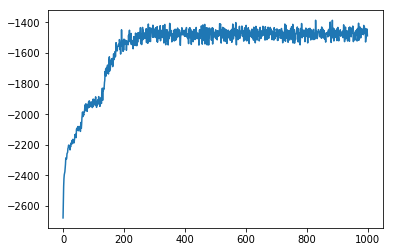

In [113]:
plt.plot(scores)
plt.show()